#Parabolic SAR

   Unnamed: 0            datetime     open     high      low    close   volume
0       54841 2020-01-01 00:00:00  7189.43  7190.52  7175.25  7177.93  416.421
1       54842 2020-01-01 00:03:00  7177.77  7182.60  7172.94  7175.61  200.423
2       54843 2020-01-01 00:06:00  7175.61  7182.06  7175.61  7182.06   73.226
3       54844 2020-01-01 00:09:00  7182.06  7188.10  7180.76  7183.07  159.842
4       54845 2020-01-01 00:12:00  7183.66  7183.66  7175.70  7176.26  187.425


  0%|          | 0/525600 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['signals'][i] = 0
<ipython-input-10-2fee271dbfa9>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signals'][i] = 0
<ipython-input-10-2fee271dbfa9>:76: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a 

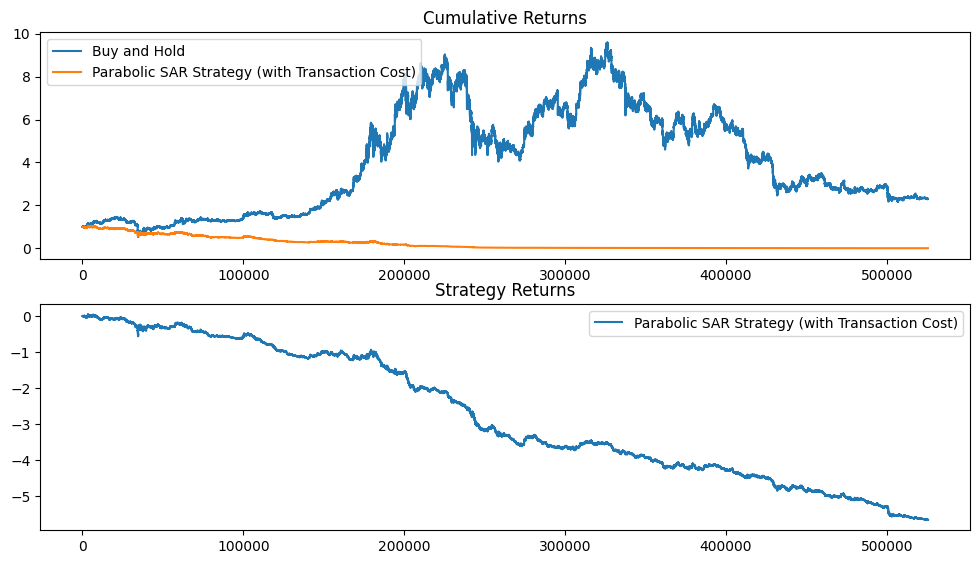

Sharpe Ratio: -2.7161


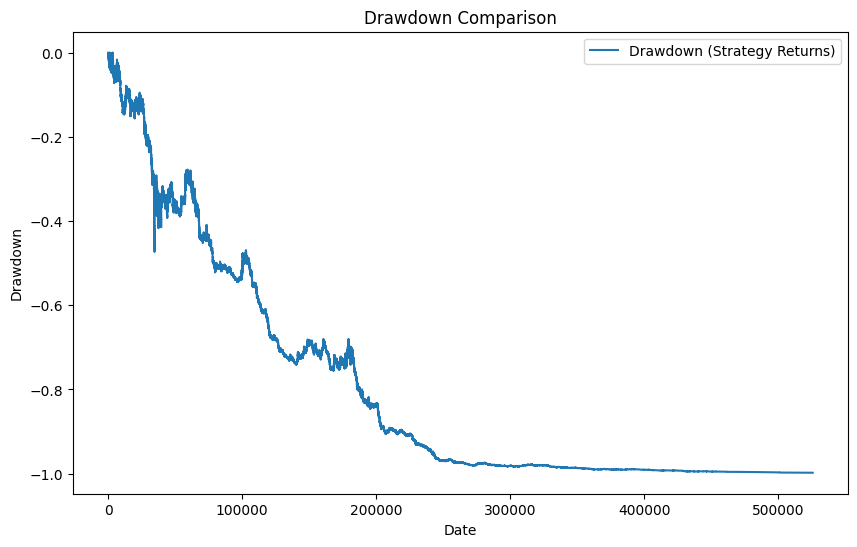

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

# Load the data from the new file path
data = pd.read_csv('/content/BTC_2019_2023_3m.csv')

# Convert the 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Filter data to only include dates from 2020 to 2022
data = data[(data['datetime'] >= '2020-01-01') & (data['datetime'] <= '2022-12-31')].reset_index(drop=True)

# Display the first few rows of the filtered data
print(data.head())

# Transaction cost per trade
TRANSACTION_COST = 0.0015

# Initialize Position and signals columns
data['Position'] = 0
data['signals'] = 0

# Parameters for the Parabolic SAR (default acceleration factor and maximum step)
acceleration_factor = 0.02
acceleration_max = 0.2
sar = [np.nan] * len(data)  # Initialize with NaNs to match the length of `data`
long_position = False  # Flag for tracking current position
af = acceleration_factor  # Initial acceleration factor
ep = 0  # Extreme Point

# Parabolic SAR calculations
for i in tqdm_notebook(range(1, len(data))):
    if i == 1:  # Initial value for SAR (could be the previous high/low)
        sar[i] = data['low'][0]
        ep = data['high'][0] if data['close'][0] > sar[0] else data['low'][0]
    else:
        # Update SAR based on the trend direction
        if long_position:  # Uptrend
            new_sar = sar[i-1] + af * (ep - sar[i-1])
            if data['low'][i] < new_sar:
                long_position = False
                sar[i] = ep
                af = acceleration_factor
                ep = data['low'][i]
            else:
                sar[i] = new_sar
                if data['high'][i] > ep:
                    ep = data['high'][i]
                    af = min(af + acceleration_factor, acceleration_max)
        else:  # Downtrend
            new_sar = sar[i-1] - af * (sar[i-1] - ep)
            if data['high'][i] > new_sar:
                long_position = True
                sar[i] = ep
                af = acceleration_factor
                ep = data['high'][i]
            else:
                sar[i] = new_sar
                if data['low'][i] < ep:
                    ep = data['low'][i]
                    af = min(af + acceleration_factor, acceleration_max)

data['SAR'] = sar

# Generate buy/sell signals based on Parabolic SAR
for i in range(1, len(data) - 1):
    if data['SAR'][i] < data['close'][i] and data['SAR'][i - 1] > data['close'][i - 1]:
        data['Position'][i + 1] = 1  # Buy signal
        data['signals'][i + 1] = 1
    elif data['SAR'][i] > data['close'][i] and data['SAR'][i - 1] < data['close'][i - 1]:
        data['Position'][i + 1] = 0  # Sell signal
        data['signals'][i + 1] = -1
    else:
        data['Position'][i + 1] = data['Position'][i]
        data['signals'][i] = 0

# Calculate returns and apply transaction costs
data['DailyReturns'] = data['close'].pct_change()
data['StrategyReturns'] = data['Position'] * data['DailyReturns']

# Subtract transaction costs where there is a trade (i.e., where signals indicate a buy or sell)
data['TransactionCost'] = np.where(data['signals'] != 0, TRANSACTION_COST, 0)
data['StrategyReturns'] -= data['TransactionCost']

# Calculate cumulative returns for strategy and buy-and-hold
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod()

# Compute mean and standard deviation of strategy returns
average_strategy_return = data['StrategyReturns'].mean()
std_dev_strategy_return = data['StrategyReturns'].std()

# Save results to a file to avoid output truncation
with open("strategy_output.txt", "w") as f:
    f.write(f"Cumulative Returns:\n{data['CumulativeReturns']}\n")
    f.write(f"Cumulative Strategy Returns:\n{data['CumulativeStrategyReturns']}\n")
    f.write(f"\nAverage Strategy Return: {average_strategy_return}\n")
    f.write(f"Standard Deviation of Strategy Return: {std_dev_strategy_return}\n")

# Plot the results
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(data['CumulativeReturns'], label='Buy and Hold')
plt.plot(data['CumulativeStrategyReturns'], label='Parabolic SAR Strategy (with Transaction Cost)')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(3, 1, 2)
plt.plot(data['StrategyReturns'].cumsum(), label='Parabolic SAR Strategy (with Transaction Cost)')
plt.legend()
plt.title('Strategy Returns')

plt.show()

# Calculate the Sharpe Ratio
sharpe_ratio = (365 * 24 * 12 * average_strategy_return - 0.042) / (np.sqrt(365 * 24 * 12) * std_dev_strategy_return)
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')

# Save Sharpe Ratio to the file
with open("strategy_output.txt", "a") as f:
    f.write(f"\nSharpe Ratio: {sharpe_ratio:.4f}\n")

# Drawdown calculation and plot
data['DrawdownStrategy'] = data['CumulativeStrategyReturns'] / data['CumulativeStrategyReturns'].cummax() - 1
plt.figure(figsize=(10, 6))
plt.plot(data['DrawdownStrategy'], label='Drawdown (Strategy Returns)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdown Comparison')
plt.legend()
plt.show()

# Save drawdown data to the file
with open("strategy_output.txt", "a") as f:
    f.write("\nDrawdown Data:\n")
    f.write(data['DrawdownStrategy'].to_string())

# Clean up the DataFrame and save the final data without columns used for calculations
data1 = data.drop(['Position', 'SAR', 'DailyReturns', 'StrategyReturns', 'CumulativeReturns', 'CumulativeStrategyReturns', 'DrawdownStrategy', 'TransactionCost'], axis=1)
data1.to_csv('data.csv', index=True)
